# Método de Simulación

### Grupo 8

- Javier Darna Sequeiros
- Tingyun Wei
- Zihao Hong

*Máster Universitario en Inteligencia Artificial*

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.integrate import quad
import pandas as pd
from IPython.display import Image

import zignor

import random
from scipy import stats
from scipy.stats import poisson, norm, chi2, expon, uniform
from enum import Enum

import logging

### 1. Generación de números y variables aleatorias
Describir el algoritmo de Ziggurat para	distribuciones con función de densidad decreciente y compararlo	con	otros métodos para la generación de	valores	de la normal

El **algoritmo de Ziggurat** es un método para generar valores aleatorios a partir de una función de densidad monótona decreciente, como la de la distribución exponencial. Sin embargo también se puede aplicar a distribuciones unimodales simétricas, como la distribución normal, generando un valor para la mitad decreciente de la función y  eligiendo aleatoriamente su signo.  

Su nombre proviene de unos templos construidos en la antigua Mesopotamia. Durante el algoritmo, se genera un conjunto de rectángulos "*apilados*" que recordaron a su autor a esta estructura.

<img src="docs/images/ziggurat.png" width="300" height="300">

Este algoritmo está basado el método de rechazo:  

> Primero, generamos puntos aleatorios dentro del rectángulo azul siguiendo una distribución uniforme y luego descartamos  todos los puntos que han quedado por encima de la curva de la distribución, es decir aquellos puntos ($x_{n}$, $y_{n}$) tales que $y_{n}$ > $f(x)$, siendo $f(x)$ la función de distribución de la que queremos generar valores. Posteriormente tomamos la coordenada *x* de cada uno de los puntos restantes, obteniendo así los números.  

La eficiencia de este método suele ser baja porque muchos puntos generados acaban siendo descartados.

<img src="docs/images/1.png" width="300" height="300">

Si pudiéramos modificar el área de generación de puntos de forma que sea lo más parecida posible, y esta es la idea básica del algoritmo de Ziggurat. Específicamente, el algoritmo de Ziggurat funciona de la siguiente manera:

> Dada una función de densidad de probabilidad decreciente $f(x)$, definida para todo $x ≥ 0$, definimos la base del Ziggurat como el conjunto de puntos dentro de la distribución.  

> En primer lugar, dividimos el área debajo de la curva en $n-1$ rectángulos y una cola. Siendo $z_k (k=0,1,...,n-1)$ una sucesión creciente tal que $z_0=0$, formamos el rectángulo $m=1,2,…,n-1$ tomando como esquina superior izquierda el punto $(0,f(z_(m-1) ))$ y como esquina inferior derecha el punto $(z_m,f(z_m ))$, y finalmente definimos la cola como los puntos bajo la curva con ordenada inferior a $f(z_{n-1})$. Los $z_k$ se eligen de forma que las n regiones tengan la misma área. Para generar números elegimos uniformemente una de las regiones y aplicamos el método del rechazo en esa región.  

> En la figura 2, se toma $n=8$, pero en la práctica n puede alcanzar 64, 128 o 256. Llamamos a la parte que se superpone al rectángulo superior en la dirección de la longitud región central del rectángulo actual. El rectángulo superior no tiene región central. 

<img src="docs/images/2.png" width="300" height="300">

**Inicialización**

Para un número especificado n de secciones, podemos resolver numéricamente una ecuación trascendente para encontrar $z_(n-1)$, el punto donde la cola infinita se encuentra con la última sección rectangular. Una vez conocemos $z_n$, podemos calcular el área común de las secciones y los otros puntos $z_k$.  También es posible dividir los rectángulos en dos porciones horizontalmente: la porción (generalmente más grande) de $0$ a $z_(k-1)$ que está completamente contenida dentro de la distribución deseada y llamamos porción central del Ziggurat, y la porción (pequeña) de $z_(k-1)$ a $z_k$, que está solo parcialmente contenida. De esta manera, se puede calcular $σ_k=z_(k-1)/z_k$, que es la fracción de las longitudes de las dos capas de rectángulos adyacentes en dirección horizontal. El borde derecho de la porción central es la línea de puntos en nuestra figura. El rectángulo superior no tiene región central y $σ_1=0$.

El cálculo de los $z_k$ y $σ$ solo necesita realizarse una vez en la inicialización.

**Algoritmo**

Una vez realizada la inicialización, los números aleatorios se pueden generar rápidamente. Calculamos un entero aleatorio $j$, entre $1$ y $n$, con distribución uniforme para elegir una región y un número real aleatorio $u$, distribuido uniformemente entre $−1$ y $1$. Luego comprobamos para ver si $u<σ_j$, es decir si $u$ cae en la porción central de la sección $j$. Si es así, entonces sabemos que $u*z_j$ es la coordenada $x$ de un punto debajo de la función de densidad de probabilidad y este valor se puede devolver como una muestra de la distribución. El pseudocódigo resultante sería el siguiente:

 j = randint(1,n);
  	u = 2*rand()-1;
  	if u < sigma[j]
     		r = u*z[j];
  	end

En el pseudo código anterior, la condición $u < sigma[j]$ se considera verdadera en la mayoría de los casos, y en caso contrario habría que realizar operaciones adicionales. Específicamente, hay tres casos posibles en los que la condición no se cumple: 

> 1. $j=1$, ya que el rectángulo superior no tiene porción central;  
2. $2≤j≤(n-1)$ y $u*z_j$ cae fuera de la porción central (es decir, en el pequeño rectángulo que contiene la curva en el lado derecho);   
3. $j=n$, $u*z_j$ cae en la cola fuera de la porción central inferior. 

En estos tres casos, es necesario realizar operaciones adicionales basadas en el **algoritmo de Box-Muller** utilizando los números aleatorios distribuidos uniformemente que se han generado para generar un número aleatorio según la distribución. Es fácil ver que cuanto mayor sea $n$, menos probable será la ocurrencia de estos tres casos que requieran operaciones adicionales. Según los datos proporcionados en el libro *Numerical Computing with MATLAB*, cuando $n=128$, la probabilidad de requerir operaciones adicionales es inferior al 3%, por lo que esta operación adicional tiene poco efecto sobre la eficiencia general del algoritmo de Ziggurat.


#### Comparación con otros métodos:

**Método de rechazo**: La idea es simple y fácil de implementar, pero puede ser muy ineficiente por dos motivos:
1. Se rechaza una gran proporción de muestras.  
2. Se debe evaluar f(x) para cada punto candidato, lo cual es computacionalmente costoso para muchas funciones de distribución de probabilidad.

**Método de inversión**: Es más complejo, usando directamente la función inversa de la función de distribución acumulativa (FDA) para generar números aleatorios. Además el cálculo implica una función de error más compleja que puede ser no primaria.

**Box-Muller**: Ha sido un algoritmo muy utilizado para generar números aleatorios durante mucho tiempo. El algoritmo Box-Muller se caracteriza por una alta eficiencia y un proceso de cálculo relativamente simple (solo se utilizan funciones elementales), que requieren al menos un logaritmo y un cálculo de raíz cuadrada para los valores generados.

**El algoritmo de Ziggurat**: Es muy eficiente y utilizado por muchos lenguajes de programación modernos. El algoritmo de Ziggurat es en realidad una versión mejorada del método de rechazo. Solo requiere generar aleatoriamente un entero y un real, seguido por una comparación, una operación de multiplicación y una búsqueda en una tabla para obtener un número aleatorio que obedezca a la distribución normal. En todo el proceso, no hay operaciones complicadas, como raíces cuadradas, logaritmos o funciones trigonométricas, al menos en la mayoría de los casos. Sin embargo, dado que el algoritmo de Ziggurat es más complejo de implementar, es mejor usarlo cuando se requieren grandes cantidades de números aleatorios.



#### Creación de la tabla la distribución normal estándar

Utilizando el algoritmo	de Ziggurat obtener	una	aproximación de	la tabla de	la tabla de	la distribución normal estándar.	

Para poder entender de dónde provienen los valores de la tabla, es importante saber acerca de la función de densidad de probabilidad (FDP). Se utiliza esta FDP para especificar la probabilidad de que una variable aleatoria caiga dentro de un rango particular de valores, en lugar de tomar cualquier valor. Esta probabilidad viene dada por la integral de la FDP de la variable sobre el rango. La siguiente ecuación es la función de densidad de probabilidad para una distribución normal $N(μ,σ^2)$.
 $f(x|\mu,\sigma^2) = \frac{1}{ \sqrt{(2 \pi \sigma^2}} \, e^{-\frac{(x-\mu^2)}{2 \sigma^2}}$ 
 
 La cual podemos simplificar tomando la distribución normal estándar de media (μ) 0 y desviación estándar (σ) 1.
 $f(x) = \frac{1}{ \sqrt{(2 \pi}} \, e^{-\frac{(x^2)}{2}}$

In [2]:
def pdf_standard_normal_distribution(x):
    return (1 / (np.sqrt(2 * np.pi))) * np.exp((x ** 2) / -2)

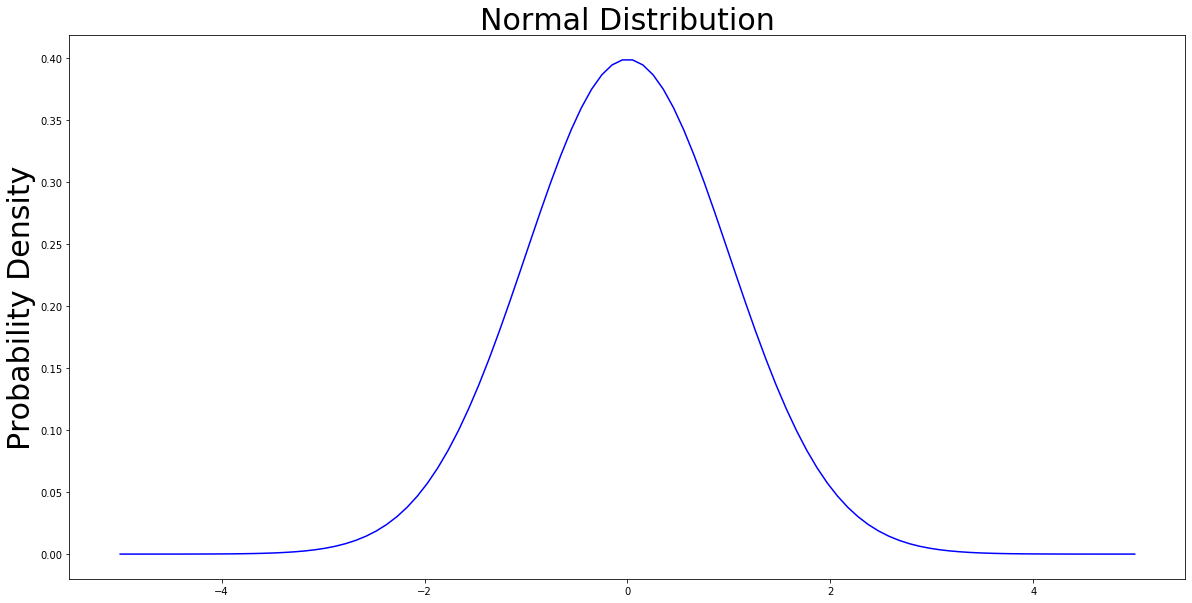

In [3]:
DOMAIN = 5
N = 100
TITLE_SIZE = 30
FIGURE_SIZE = (20, 10)

domain = np.linspace(-DOMAIN, DOMAIN, N) # return a domain from [0, 1] in 100 parts

fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], FIGURE_SIZE[1]));

# config
ax.set_title('Normal Distribution', size = TITLE_SIZE);
ax.set_ylabel('Probability Density', size = TITLE_SIZE);

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'b')

plt.show()

La tabla de la normal estándar contiene los datos de la probabilidad de un evento dentro del intervalo $[0, z]$, es decir, el área bajo la curva normal estándar entre $0$ y $z$. El gráfico anterior no muestra la probabilidad de eventos, sino su densidad de probabilidad. Para encontrar el área, necesita integrarse. La integración del FDP proporciona una función de distribución acumulativa (FDA), que asigna valores a su rango de percentil en una distribución. Los valores de la tabla se calculan utilizando la función de distribución acumulativa de una distribución normal estándar con media 0 y desviación estándar 1. Esto se puede denotar con la siguiente ecuación.  
  
$\int_{0}^{z}{\frac{1}{2\pi}}e^{\frac{-x^2}{2}}dx$

En esta práctica vamos a utilizar el algoritmo de Ziggurat para crear la tabla. El primer paso es generar $n$ números aleatorios según la distribución normal utilizando el algoritmo. En nuestro caso, generamos 10000, cambiamos su signo aleatoriamente y los truncamos a 2 decimales. Después, establecemos un contador para calcular la acumulación de cada valor del número aleatorio y lo normalizamos. De esta manera, obtenemos la frecuencia de cada valor, la cual usamos como aproximación del valor correspondiente de la función de densidad. 

Con el objetivo de obtener la probabilidad acumulada dentro de un rango desde 0 hasta un valor $z$ del numero aleatorio, se suman todas las frecuencias calculadas de los valores de los números menores que $z$. En esta práctica, se han generado las 10 primeras filas de la tabla, es decir, se han calculado las probabilidades acumuladas de los valores $z$ desde 0 hasta 0.99. No se muestran las probabilidades para los $z$ negativos ya que $F(-z)=1-F(z)$.

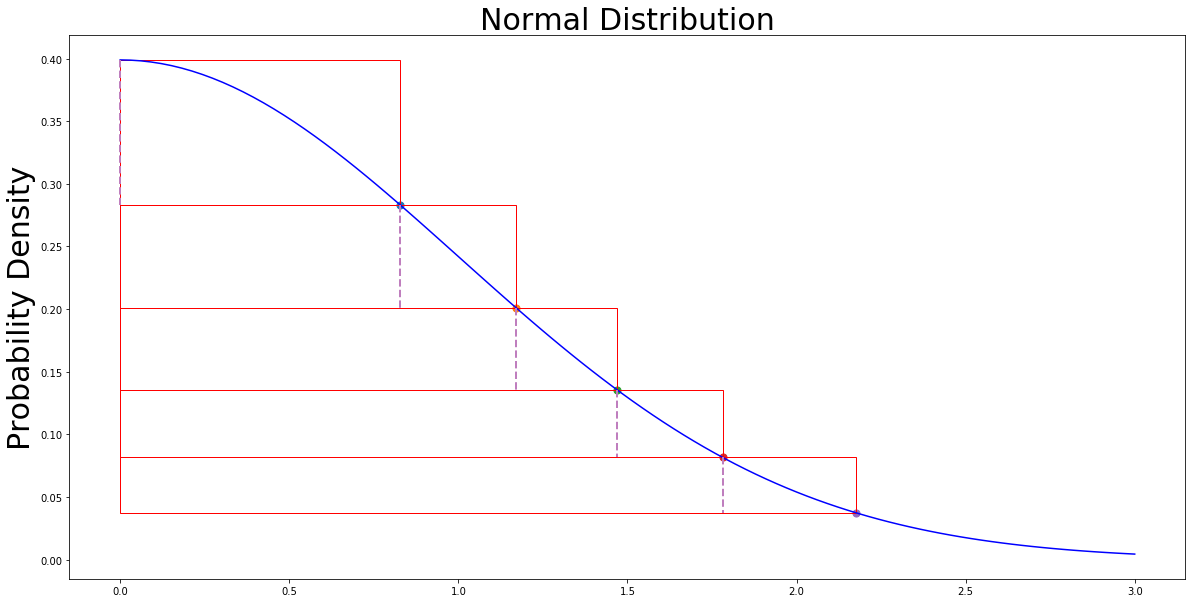

In [4]:
DOMAIN = 3
N = 100
POINT_SIZE = 50
TITLE_SIZE = 30
FIGURE_SIZE = (20, 10)

domain = np.linspace(0, DOMAIN, N) # return a domain from [0, 1] in 100 parts

divisions = [0, 0.8288, 1.1713, 1.4696, 1.7819, 2.1761]

fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], FIGURE_SIZE[1]));

# config
ax.set_title('Normal Distribution', size = TITLE_SIZE);
ax.set_ylabel('Probability Density', size = TITLE_SIZE);

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'b')
currentAxis = plt.gca()

for i in range(1, len(divisions)):
    y = pdf_standard_normal_distribution(divisions[i]) # calculate its y axis value
    y_prev = pdf_standard_normal_distribution(divisions[i - 1]) # calculate divisions i - 1 y axis value
    
    plt.scatter(divisions[i], y, s = POINT_SIZE) # draw point s is size
    rect = patches.Rectangle((0, y), divisions[i], y_prev - y, linewidth = 1, edgecolor = 'r', fill = None) # draw rectangle
    plt.plot([divisions[i - 1], divisions[i - 1]], [y_prev, y], color = '#BF7EBE', linewidth = 2, linestyle = 'dashed') # draw lines
    
    currentAxis.add_patch(rect) # add rectangle

plt.show()
plt.close()

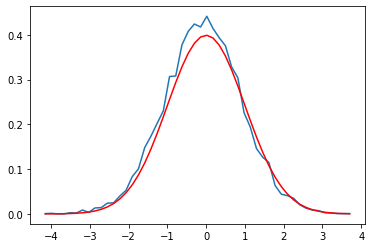

In [5]:
bins = 50
N = 10000

random_numbers = zignor.randn(N)

plt.figure()
hist, bin_edges = np.histogram( random_numbers, bins )
histNorm = hist / 1500 #TODO: encontrar una forma de calcular este 1500
plt.plot( bin_edges[:-1], histNorm )
plt.plot( bin_edges[:-1],
          [pdf_standard_normal_distribution(x) for x in bin_edges[:-1]],
          color = 'r' )
plt.show()

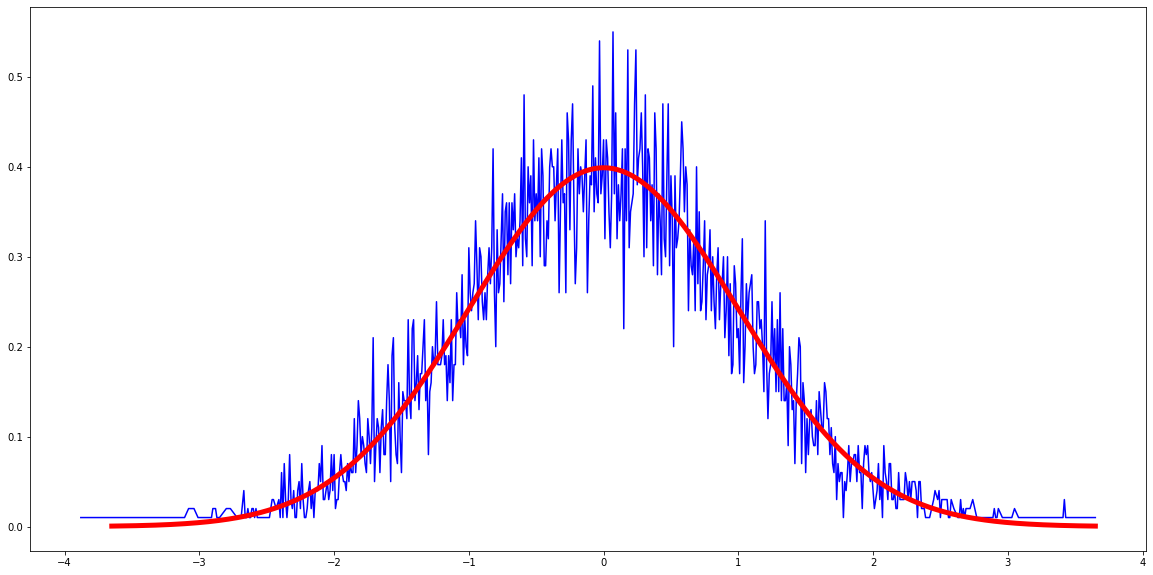

In [6]:
POINT_SIZE = 50
N = 10000

random_numbers = zignor.randn(N)

counter = {}
for rand in random_numbers:
    round_rand_number = np.round(rand, 2) # round the number to 2 decimals
    counter[round_rand_number] = counter.get(round_rand_number, 0) + 1
    
x_axis = sorted(list(counter.keys()))
y_axis = list(map(lambda x : counter[x] / N * 100, x_axis))

domain = np.linspace(-max(x_axis), max(x_axis), N)

fig, ax = plt.subplots(figsize = (FIGURE_SIZE[0], FIGURE_SIZE[1]));

ax.plot(x_axis, y_axis, color = 'b')

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'r', linewidth = 5)

plt.show()

In [7]:
standard_normal_table = pd.DataFrame(
    data =[],
    index = np.round(np.arange(0, 1, .1), 2),
    columns = np.round(np.arange(0.00, .1, .01), 2)
)

for index in standard_normal_table.index:
    for column in standard_normal_table.columns:
        z = np.round(index+column, 2)
        value = 0
        for k in np.round(np.arange(min( random_numbers ), z, .01), 2):
            if counter.get( k ) is not None:
                value = value + counter.get(k)
        standard_normal_table.loc[index, column] = value / N
        
standard_normal_table.index = standard_normal_table.index.astype(str)
standard_normal_table.columns = [str(column).ljust(4, '0') for column in standard_normal_table.columns]

standard_normal_table

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
0.0,0.501,0.5053,0.5085,0.5128,0.5169,0.5204,0.5235,0.5272,0.5327,0.5364
0.1,0.541,0.5442,0.548,0.5514,0.5551,0.5593,0.5615,0.5657,0.5691,0.5744
0.2,0.5775,0.581,0.5846,0.5883,0.593,0.5983,0.6021,0.6062,0.6104,0.615
0.3,0.619,0.622,0.6268,0.6299,0.6341,0.6382,0.6416,0.6454,0.6483,0.6529
0.4,0.6571,0.6599,0.6636,0.667,0.6698,0.6745,0.6777,0.6807,0.6846,0.6893
0.5,0.6922,0.6961,0.6995,0.7015,0.7054,0.7085,0.7117,0.7151,0.719,0.7235
0.6,0.7277,0.7312,0.7352,0.739,0.7414,0.7447,0.7476,0.7504,0.7536,0.756
0.7,0.76,0.7627,0.7662,0.7686,0.7711,0.774,0.7774,0.7797,0.7825,0.7854
0.8,0.7887,0.7911,0.7941,0.7966,0.7988,0.8016,0.8047,0.807,0.8097,0.8124
0.9,0.8154,0.8175,0.8199,0.8229,0.8248,0.8275,0.8292,0.831,0.8339,0.8366


### 2. Simulación de sucesos discretos.
Llegan petroleros para descargar en el muelle según un proceso de Poisson no homogéneo con la siguiente tasa:

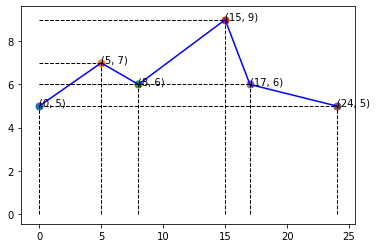

In [8]:
POINT_SIZE = 50

values = [(0, 5), (5, 7), (8, 6), (15, 9), (17, 6), (24, 5)]
x_axis = list(map(lambda x : x[0], values))
y_axis = list(map(lambda y : y[1], values))

fig, ax = plt.subplots()
plt.plot(x_axis, y_axis, color = 'b')
for i in values:
    plt.scatter(i[0], i[1], s = POINT_SIZE) # draw point s is size
    ax.annotate("(" + str(i[0]) + ", " + str(i[1]) + ")", (i[0], i[1])) # add labels
    plt.plot([i[0], i[0]], [0, i[1]], color = 'black', linewidth = 1, linestyle = 'dashed') # draw vertical lines
    plt.plot([0, i[0]], [i[1], i[1]], color = 'black', linewidth = 1, linestyle = 'dashed') # draw horizontal lines
plt.show()


El petrolero llega hasta la entrada del puerto, y espera a que un remolcador 
esté disponible y lo lleve hasta el muelle. Se disponen en el puerto de 10 
remolcadores.

Los remolcadores también realizan la labor de llevar cada petrolero hasta la 
entrada del puerto tras haber descargado. En el fichero “desplazamientos.txt”
se dispone de una muestra de las duraciones de los desplazamientos del
remolcador con el petrolero. Contrástese si la distribución de dichos tiempos es
normal (truncada), uniforme o exponencial y estímense los parámetros de la
distribución correspondiente.

In [9]:
# input data
file= open('docs/data/E8.desplazamientos.txt')
data_desplazamiento= np.loadtxt(file, unpack='true')
file.close()

In [10]:
#  scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two_sided', mode='approx', **kwds)
# rvs --> test data; cdf --> distribution type，'norm'，'expon'，'rayleigh'，'gamma'；args=() distribution parametric
# N: if vs is string，N is the size of sample
# if p-value is bigger than the level of significance（5％），accept H0，The sample data can be considered to be from a given distribution F(x)
loc, scale = norm.fit(data_desplazamiento)
n = norm(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, n.cdf)

KstestResult(statistic=0.01035501786004428, pvalue=0.6571586727422323)

$D_{n}^{+}=\max(F_{n}(x)-F(x))$

By the Glivenko–Cantelli theorem, if the sample comes from distribution F(x), then Dn converges to 0 almost surely in the limit when n goes to infinity.

kstest(rvs, cdf, args=(), N=20, alternative=’two_sided’, mode=’approx’, **kwds)

alternative：default as two-sided test，also can be ‘less’ o ‘greater’ for one-sided test

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html

In [11]:
loc, scale = uniform.fit(data_desplazamiento)
u = uniform(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, u.cdf)

KstestResult(statistic=0.2177462278558, pvalue=2.43873358745901e-206)

In [12]:
loc, scale = expon.fit(data_desplazamiento)
ex = expon(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, ex.cdf)

KstestResult(statistic=0.3581258415266688, pvalue=0.0)

In [13]:
# method of moments --> estimate parametrics of a normal distribution
mu = np.mean(data_desplazamiento)
sigma = np.std(data_desplazamiento)
print("Mu: " + str(mu))
print("Sigma: " + str(sigma))

Mu: 10.007615178514001
Sigma: 3.0373964893054275


In [14]:
stats.anderson(data_desplazamiento, dist='expon')

AndersonResult(statistic=1106.7655637247299, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Cuando el remolcador va de vacío (sin remolcar) la distribución es también 
normal pero con media de 2 minutos y desviación típica 1. 

Existe un número limitado de 20 muelles donde pueden atracar los 
petroleros. El tiempo de descarga de cada petrolero tiene una distribución 
chi cuadrado con 2 grados de libertad, expresada en horas. 

El remolcador da prioridad a los petroleros que llegan sobre los que 
abandonan el puerto.
A. Simule el comportamiento del puerto para estimar el tiempo medio 
que tardan en atracar los barcos, el tiempo máximo en atracar, el 
número medio de barcos atracados en el puerto y el número medio y 
máximo de barcos esperando a atracar.
B. Analice la posibilidad de disponer de 3 nuevos remolcadores y 
realizar obras para disponer de 5 nuevos muelles ¿cuál de las dos 
opciones es mejor?

Una distribución de Poisson da la probabilidad de varios eventos en un intervalo generado por un proceso de Poisson. La distribución de Poisson se define mediante el parámetro de velocidad, λ, que es el número esperado de eventos en el intervalo (eventos / intervalo * duración del intervalo) y el número más alto de probabilidad de eventos. También podemos usar la Distribución de Poisson para encontrar el tiempo de espera entre eventos. Incluso si llegamos a un tiempo aleatorio, el tiempo de espera promedio siempre será el tiempo promedio entre eventos.


In [15]:
# Params

LOG_FILE = 'ports.log'
# Num of tugs available
MAXTUGS = 10
# Num of wharves available
MAXWHARVES = 20
# Max time
T = 7 * 24 * 60 # 7 days
TUG_MU_EMPTY = 2
TUG_SIGMA_EMPTY = 1
TUG_MU_FULL = mu
TUG_SIGMA_FULL = sigma
WHARVE_FREEDOM_DEGREE = 2

In [16]:
def minutesToTime(minutes):
    hours = int(minutes / 60)
    seconds = int( (minutes - int(minutes)) * 60)
    minutes = int(minutes - hours * 60)
    days = int(hours/24)
    hours = hours - days*24
    return str(days) + "d " + str(hours) + "h " + str(minutes) + "min " + str(seconds) + "s"

In [17]:
# Returns the poisson proccess rate
# t: time in minutes along a month
# As t could be any minute in a month, we need to get the t in minutes in the day

def getPoissonRate(t):
    lambd = 0
    h_in_day = (t / 60.0) % 24.0
    if h_in_day >= 0.0 and h_in_day < 5.0:
        lambd = 2.0 / 5.0 * h_in_day + 5.0
    elif h_in_day >= 5.0 and h_in_day < 8.0:
        lambd = -1.0 / 3.0 * h_in_day + 26.0 / 3.0
    elif h_in_day >= 8.0 and h_in_day < 15.0:
        lambd = 3.0 / 7.0 * h_in_day + 18.0 / 7.0
    elif h_in_day >= 15.0 and h_in_day < 17.0:
        lambd = -3.0 / 2.0 * h_in_day + 63.0/2.0
    elif h_in_day >= 17.0 and h_in_day < 24.0:
        lambd = -1.0 / 7.0 * h_in_day + 59.0 / 7.0
    else: 
        logging.error("lambda out of index")
    return lambd;

# used for poisson distribution and exponential distribution
    

In [18]:
#Enumeracion que contiene los tipos de eventos posibles
class Events(Enum):  
    TANK_ARRIVAL = 0 # Indica la entrada de un barco al puerto.
    TANK_UNLOADED = 3 # Barco descargando
    TUG_AT_WHARVE = 38 # Indica la llegada de un remolcador a los muelles.
    TUG_AT_ENTRANCE = 58 # Indica la llegada de un remolcador a la entrada del puerto.

# Clase para guardar una lista de eventos. Cada elemento es una tupla con
# el momento en el que ocurre el evento y el tipo de evento.
class ListEvents():
    L = []
    
    def __init__( self ):
        self.L = []
    
    # Para ordenar la lista con la funcion sorted(), devuelve el momento del evento
    def comparator(self, value):
        return value[0]
    
    # Returns the size of the list
    def size(self):
        return len(self.L)
    
    #Anade un evento a partir del momento y el tipo. Ademas ordena la
    #lista para que los eventos queden en orden cronologico.
    def add(self, time, event_type, tank_id = None):
        #logging.info("New event arrived at events list: " + event_type.name + " :" + str(time))
        self.L.append((time, event_type, tank_id))
        self.L = sorted(self.L, key = self.comparator)
    
    #Saca y devuelve el primer elemento de la lista.
    def pop_front(self):
        event_time, event, tank_id = self.L[0]
        #logging.info("Processing event: " + event.name + " :" + str(event_time))
        self.L = self.L[1:]
        return event_time, event, tank_id
    
    #Devuelvo el momento del evento con indice index.
    def get_time( self, index ):
        return self.L[index][0]
    
    #Devuelvo el tipo del evento con indice index.
    def get_event_type( self, index ):
        return self.L[index][1]

In [19]:
class ListTankers:
    def __init__(self):
        self.L = []
        
    def add(self, time_event):
        tank = {
            "id": len(self.L) + 1,
            "arrival_time": time_event,
            "entrance_pick_by_tug_time" : -1,
            "wharve_arrival_time" : -1,
            "wharve_unload_done_time" : -1,
            "wharve_pick_by_tug_time" : -1,
            "exit_time" : -1
        }
        self.L.append(tank)
        return tank
    
    def get(self, tank_id):
        for i in self.L:
            if i["id"] == tank_id:
                return i
        return None

In [20]:
class ListTugs():
    L = []
    
    def __init__( self, max_tugs ):
        self.L = [None] * max_tugs
        self.max_tugs = max_tugs
    
    # Para ordenar la lista con la funcion sorted(), devuelve el tiempo de fin de descarga
    def comparator(self, value):
        return value[0]
    
    #Anade un evento a partir del momento y el tipo. Ademas ordena la
    #lista para que los eventos queden en orden cronologico.
    def add(self, tank_id):
        if self.size() >= self.max_tugs:
            logging.error("Error: max size exceeded")
            return None
        for i, x in enumerate(self.L):
            if x is None:
                self.L[i] = tank_id
                break
        
    def remove(self, tank_id):
        for i, x in enumerate(self.L):
            if x == tank_id:
                self.L[i] = None
                break
    
    def get_waiting_ids( self, time ):
        return [x[0] for x in self.L if x[1]]
    
    def size(self):
        return len(list(filter(lambda x: x is not None, self.L)))

In [21]:
#Clase con informacion sobre el contenido de los muelles. Cada elemento
#contiene una id de barco y el tiempo de fin de descarga
class ListWharves():
    L = []
    
    def __init__( self, max_wharves ):
        self.L = [None] * max_wharves
        self.max_wharves = max_wharves
    
    # Para ordenar la lista con la funcion sorted(), devuelve el tiempo de fin de descarga
    def comparator(self, value):
        return value[0]
    
    #Anade un evento a partir del momento y el tipo. Ademas ordena la
    #lista para que los eventos queden en orden cronologico.
    def add(self, tank_id):
        if self.size() >= self.max_wharves:
            logging.error("Error: max size exceeded")
            return None
        for i, x in enumerate(self.L):
            if x is None:
                self.L[i] = tank_id
                break
        
    def remove(self, tank_id):
        for i, x in enumerate(self.L):
            if x == tank_id:
                self.L[i] = None
                break
    
    def get_waiting_ids( self, time ):
        return [x[0] for x in self.L if x[1]]
    
    def size(self):
        return len(list(filter(lambda x: x is not None, self.L)))

In [22]:
# Clase para las simulaciones del ejecrcicio 2
class Simulation:
    def __init__(
        self, 
        tug_mu_empty = TUG_MU_EMPTY, 
        tug_sigma_empty = TUG_SIGMA_EMPTY, 
        tug_mu_full = TUG_MU_FULL, 
        tug_sigma_full = TUG_SIGMA_FULL, 
        wharve_freedom_degree = WHARVE_FREEDOM_DEGREE, 
        max_tugs = MAXTUGS, 
        max_wharves = MAXWHARVES,
        max_time = T
    ):
        logging.info("Simulation parameters initialization ...")
        
        self.list_tankers = ListTankers()
        self.tug_mu_empty = tug_mu_empty
        self.tug_sigma_empty = tug_sigma_empty
        self.tug_mu_full = tug_mu_full
        self.tug_sigma_full = tug_sigma_full
        self.wharve_freedom_degree = wharve_freedom_degree
        
        self.tankers_waiting_entrance = []
        self.tankers_finished_unloading = []
        self.tankers_exit = []
        self.list_events = ListEvents()
        self.tankers_tugs = ListTugs( max_tugs )
        self.tankers_wharves = ListWharves( max_wharves )
        
        self.time = 0.0
        self.max_time = max_time
        
        self.max_tugs = max_tugs
        self.max_wharves = max_wharves
        
        # statistics
        self.mean_time_to_dock = 0.0 # Tiempo medio que tarda un barco para llegar al muelle
        self.max_time_to_dock = 0.0 # Tiempo maximo que tarda un barco para llegar al muelle
        self.mean_tankers_docked = 0.0 # Numero medio de barcos en los muelles
        self.mean_tankers_wait_at_entrance = 0.0 # Numero medio de barcos esperando en la entrada
        self.max_tankers_wait_at_entrance = 0 # Numero maximo de barcos esperando en la entrada
        
        logging.info("Simulation parameters initialized")
        
    # Funcion para empezar la simulacion
    def simulate(self):
        logging.info("Simulation starting ...")
        
        # Calculamos la llegada del primer barco.
        x = 60 * random.expovariate(getPoissonRate(self.time))
        
        # Si el primer barco llega despues del final de la simulacion,
        # devuelve error
        if x > self.max_time:
            logging.error("No tankers arrived during simulation time. Ending...")
            return -1
        else:
            # Add the first event (the first tank arrival)
            self.list_events.add(self.time + x, Events.TANK_ARRIVAL)
            # Bucle principal en el que se tratan eventos durante el
            # tiempo de simulacion.
            while self.list_events.size() > 0:
                #Tomamos el proximo evento
                time_event, event, tank_id =  self.list_events.pop_front()
                
                self.mean_tankers_docked += self.tankers_wharves.size() * (time_event - self.time)
                self.mean_tankers_wait_at_entrance += len(self.tankers_waiting_entrance) * (time_event - self.time)
                self.max_tankers_wait_at_entrance = max(len( self.tankers_waiting_entrance), self.max_tankers_wait_at_entrance)
                
                self.time = time_event
                
                # Llamamos a diferentes rutinas segun el tipo de evento
                if event == Events.TANK_ARRIVAL:
                    self.rutina_llegada_barco()
                if event == Events.TANK_UNLOADED:
                    self.rutina_muelle(tank_id)
                if event == Events.TUG_AT_WHARVE:
                    self.rutina_remolcador_muelle(tank_id)
                if event == Events.TUG_AT_ENTRANCE:
                    self.rutina_remolcador_entrada(tank_id)
                    
                self.proceso_remolcador()
                    
                logging.info("Tugs: " + str(self.tankers_tugs.L))
                logging.info("Wharves: " + str(self.tankers_wharves.L))
                logging.info("Waiting at entrance: " + str(self.tankers_waiting_entrance))
                logging.info("Waiting at wharve: " + str(self.tankers_finished_unloading))
                logging.info("Tankers finished: " + str(self.tankers_exit))

            for i in self.list_tankers.L:
                dock_time = i["wharve_arrival_time"] - i["arrival_time"]
                self.max_time_to_dock = max(self.max_time_to_dock, dock_time)
                self.mean_time_to_dock += dock_time

            self.mean_time_to_dock /= len(self.list_tankers.L)
            self.mean_tankers_docked /= self.time
            self.mean_tankers_wait_at_entrance /= self.time
            
            logging.info("")
            logging.info("mean_time_to_dock: " + str(self.mean_time_to_dock))
            logging.info("max_time_to_dock: " + str(self.max_time_to_dock))
            logging.info("mean_tankers_docked: " + str(self.mean_tankers_docked))
            logging.info("mean_tankers_wait_at_entrance: " + str(self.mean_tankers_wait_at_entrance))
            logging.info("max_tankers_wait_at_entrance: " + str(self.max_tankers_wait_at_entrance))
            logging.info("")
                    
            return 0
        
    def proceso_remolcador(self):
        y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
        yy = y + random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            
        if self.tankers_tugs.size() < self.max_tugs:
            if len(self.tankers_waiting_entrance) > 0 and self.tankers_wharves.size() < self.max_wharves:
                tank_id = self.tankers_waiting_entrance[0]
                self.tankers_waiting_entrance = self.tankers_waiting_entrance[1:]
                
                tank = self.list_tankers.get(tank_id)
                if tank is not None:
                    self.tankers_tugs.add(tank["id"])
                    self.tankers_wharves.add(tank["id"])
                    self.list_events.add(self.time + y, Events.TUG_AT_WHARVE, tank["id"])
                    
                    logging.info("Tug tugging tanker " + str(tank["id"]) + " to wharve")
                    
                    tank["entrance_pick_by_tug_time"] = self.time + y
            elif len(self.tankers_finished_unloading) > 0:
                tank_id = self.tankers_finished_unloading[0]
                self.tankers_finished_unloading = self.tankers_finished_unloading[1:]
                
                tank = self.list_tankers.get(tank_id)
                if tank is not None:
                    self.tankers_tugs.add(tank["id"])
                    self.list_events.add(self.time + y, Events.TUG_AT_ENTRANCE, tank["id"])
                    
                    logging.info("Tug tugging tanker " + str(tank["id"]) + " to entrance")
                    
                    tank["wharve_pick_by_tug_time"] = self.time + y
        
    # Rutina para la llegada de un barco
    def rutina_llegada_barco(self):
        tank = self.list_tankers.add(self.time)
        
        logging.info(str(self.time) + " --- " + minutesToTime(self.time) + ": TANKER " + str(tank["id"]) + " arrived at port")
        
        # Generamos el momento de llegada del siguiente barco y lo
        # anadimos a la lista de eventos si no hemos excedido el
        # tiempo de simulacion
        x = 60 * random.expovariate(getPoissonRate(self.time))
        if self.time + x > self.max_time:
            logging.info( "End of tanker arrivals." )
        else:    
            self.list_events.add(self.time + x, Events.TANK_ARRIVAL)
            
        # Anadimos el barco a la cola de entrada
        self.tankers_waiting_entrance.append(tank["id"])
        tank["arrival_time"] = self.time
    
    def rutina_muelle(self, tank_id):
        tank = self.list_tankers.get(tank_id)
        if tank is not None:
            logging.info(str(self.time) + " --- " + minutesToTime(self.time) + ": TANKER " + str(tank["id"]) + " finished unloading")

            self.tankers_wharves.remove(tank["id"])
            self.tankers_finished_unloading.append(tank["id"])
            tank["wharve_unload_done_time"] = self.time
    
    #Rutina para cuando un remolcador llega a la entrada
    def rutina_remolcador_entrada(self, tank_id):
        tank = self.list_tankers.get(tank_id)
        if tank is not None:
            logging.info(str(self.time) + " --- " + minutesToTime(self.time) + ": TANKER " + str(tank["id"]) + " back to sea")
            self.tankers_tugs.remove(tank["id"])
            self.tankers_exit.append(tank["id"])
            tank["exit_time"] = self.time
        
    #Rutina para cuando llega un remolcador a los muelles
    def rutina_remolcador_muelle( self, tank_id):
        tank = self.list_tankers.get(tank_id)
        if tank is not None:
            logging.info(str(self.time) + " --- " + minutesToTime(self.time) + ": TANKER " + str(tank["id"]) + " arrived at wharve")
            self.tankers_tugs.remove(tank["id"])
            tank["wharve_arrival_time"] = self.time

            z = 60 * np.random.chisquare(self.wharve_freedom_degree)
            self.list_events.add(self.time + z, Events.TANK_UNLOADED, tank["id"])

In [23]:
def simulation(
    log_file = "ports.log",
    tug_mu_empty = TUG_MU_EMPTY, 
    tug_sigma_empty = TUG_SIGMA_EMPTY, 
    tug_mu_full = TUG_MU_FULL, 
    tug_sigma_full = TUG_SIGMA_FULL, 
    wharve_freedom_degree = WHARVE_FREEDOM_DEGREE, 
    max_tugs = MAXTUGS, 
    max_wharves = MAXWHARVES,
    max_time = T
):
    # clear log
    open(log_file, 'w').close()
    # Setting up for a log file
    logging.basicConfig(filename=log_file, level=logging.INFO)

    simulation = Simulation(
        tug_mu_empty = tug_mu_empty, 
        tug_sigma_empty = tug_sigma_empty, 
        tug_mu_full = tug_mu_full, 
        tug_sigma_full = tug_sigma_full, 
        wharve_freedom_degree = wharve_freedom_degree, 
        max_tugs = max_tugs, 
        max_wharves = max_wharves,
        max_time = max_time
    )
    if simulation.simulate() == -1:
        logging.error("Simulation failed")
    else:
        logging.info("Simulation success")
        
simulation("ports1020.log", max_tugs = 10, max_wharves = 20)
simulation("ports1320.log", max_tugs = 13, max_wharves = 20)
simulation("ports1025.log", max_tugs = 10, max_wharves = 25)
simulation("ports1325.log", max_tugs = 13, max_wharves = 25)

### Referencia

Marsaglia, G., & Tsang, W. W. (2000). The ziggurat method for generating random variables. Journal of statistical software, 5(8), 1-7.  
https://towardsdatascience.com/how-to-use-and-create-a-z-table-standard-normal-table-240e21f36e53 